# Stock Return Prediction Case Study.



## Problem Statement
In the supervised regression framework used for this case study, the weekly return of Tesla stock is the predicted variable. We need to understand what affects Tesla's stock price and therefore incorporate as much relevant information as possible into the model.

For this case study, in addition to Tesla's historical data, the independent variables used are the following potentially correlated assets:

- Stocks: Ford (F) and General Motors (GM)
- Currency: USD/CNY and USD/EUR
- Indices: S&P 500, Dow Jones, and Nasdaq-100

## Loading the data and python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import warnings
import datetime
warnings.filterwarnings('ignore')

In [2]:
import yfinance as yf

start_date = datetime.datetime(2010, 1, 1)

# Define tickers
stk_tickers = ['TSLA', 'F', 'GM']

# Fetch data using yfinance
stk_data = yf.download(stk_tickers, group_by="ticker",start=start_date)
stk_data = stk_data.loc[:, (slice(None), 'Adj Close')]


[*********************100%***********************]  3 of 3 completed


In [3]:
index_tickers = ['^GSPC', '^DJI', '^NDX']  # S&P 500, Dow Jones, Nasdaq-100

# Fetch index data using yfinance
idx_data = yf.download(index_tickers, group_by="ticker",start=start_date)
idx_data = idx_data.loc[:, (slice(None), 'Adj Close')]


[*********************100%***********************]  3 of 3 completed


In [4]:
ccy_tickers = ['DEXCHUS', 'DEXUSEU']  # USD/CNY and USD/EU

# Fetch currency data using FRED
ccy_data = web.DataReader(ccy_tickers, 'fred',start=start_date)




Since this is a regression problem we are going to define our variables as follows.

Y: TESLA Future Returns (log return (rate of change) of TESLA's adjusted closing price over 5 days)

X:

- FORD  5 Business Day Returns
- GENERAL MOTORS 5 Business DayReturns    
- USD/CNY 5 Business DayReturns    
- USD/EU 5 Business DayReturns    
- S&P 500 5 Business DayReturns    
- Dow Jones 5 Business DayReturns    
- TESLA 5 Business Day Returns    
- TESLA 15 Business Day Returns    
- TESLA 30 Business Day Returns    
- TESLA 60 Business Day Returns


In [5]:
return_period = 5

# Log return of Tesla's adjusted closing price
Y = np.log(stk_data['TSLA']['Adj Close']).diff(return_period).shift(-return_period) # Select 'Adj Close'
Y.name = 'TSLA_pred'

# Log returns of Ford and GM
X1 = np.log(stk_data[['F', 'GM']]).diff(return_period)

# Log returns of currency and index data
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

# Additional time-period differences for Tesla using 'Adj Close'
X4 = pd.concat([np.log(stk_data['TSLA']['Adj Close']).diff(i) for i in [return_period, return_period * 3, return_period * 6, return_period * 12]], axis=1).dropna()
X4.columns = ['TSLA_DT', 'TSLA_3DT', 'TSLA_6DT', 'TSLA_12DT']

# Make all DatetimeIndexes tz-naive before concatenation
X1.index = X1.index.tz_localize(None)
X2.index = X2.index.tz_localize(None)
X3.index = X3.index.tz_localize(None)
X4.index = X4.index.tz_localize(None)
# Ensure Y's index is tz-naive as well
Y.index = Y.index.tz_localize(None) # Add this line to make Y's index tz-naive

# Combine all features
X = pd.concat([X1, X2, X3, X4], axis=1)

# Final dataset and alignment of Y and X
data = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = data.loc[:, Y.name]
X = data.loc[:, X.columns]

In [6]:
data.head()


,TSLA_pred,"(F, Adj Close)","(GM, Adj Close)",DEXCHUS,DEXUSEU,"(^NDX, Adj Close)","(^DJI, Adj Close)","(^GSPC, Adj Close)",TSLA_DT,TSLA_3DT,TSLA_6DT,TSLA_12DT
2010-11-26,-0.114780,-0.001242,-0.011473,0.004163,-0.030563,0.008926,-0.008024,-0.006110,0.166925,0.349582,0.531904,0.546467
2010-12-06,0.007887,0.036079,0.019919,-0.001758,0.013881,0.020880,0.027635,0.029336,-0.124542,0.015628,0.380379,0.407281
2010-12-13,0.036952,-0.010870,-0.019919,0.002539,0.008551,0.008023,0.005824,0.014077,0.007887,-0.014300,0.335622,0.412198
2010-12-20,-0.182574,0.022811,-0.001184,0.001394,-0.019991,0.007038,0.004328,0.005323,0.036952,-0.079703,0.260096,0.455597
2010-12-28,0.009796,-0.007148,0.045173,-0.005014,-0.000686,0.001968,0.008451,0.009124,-0.182574,-0.137735,-0.122107,0.248452


Lets rename the columns for a better understanding.

In [7]:
# Rename columns in `data` with tuple-style column names
data = data.rename(columns={
    ('F', 'Adj Close'): 'Ford',
    ('GM', 'Adj Close'): 'GM',
    ('^GSPC', 'Adj Close'): 'S&P_500',
    ('^DJI', 'Adj Close'): 'Dow_Jones',
    ('^NDX', 'Adj Close'): 'Nasdaq_100',
    'TSLA_DT': 'Tesla_Diff_5',
    'TSLA_3DT': 'Tesla_Diff_15',
    'TSLA_6DT': 'Tesla_Diff_30',
    'TSLA_12DT': 'Tesla_Diff_60',
    'DEXCHUS': 'USD_CNY',
    'DEXUSEU': 'USD_EUR'
})

# Verify the changes
print(data.columns)




Index(['TSLA_pred', 'Ford', 'GM', 'USD_CNY', 'USD_EUR', 'Nasdaq_100',
       'Dow_Jones', 'S&P_500', 'Tesla_Diff_5', 'Tesla_Diff_15',
       'Tesla_Diff_30', 'Tesla_Diff_60'],
      dtype='object')


In [8]:
print("Null values:", data.isnull().values.sum())
print("NA values:", data.isna().values.any())

Null values: 0
NA values: False


## Data Visualization

<Figure size 1600x1600 with 0 Axes>

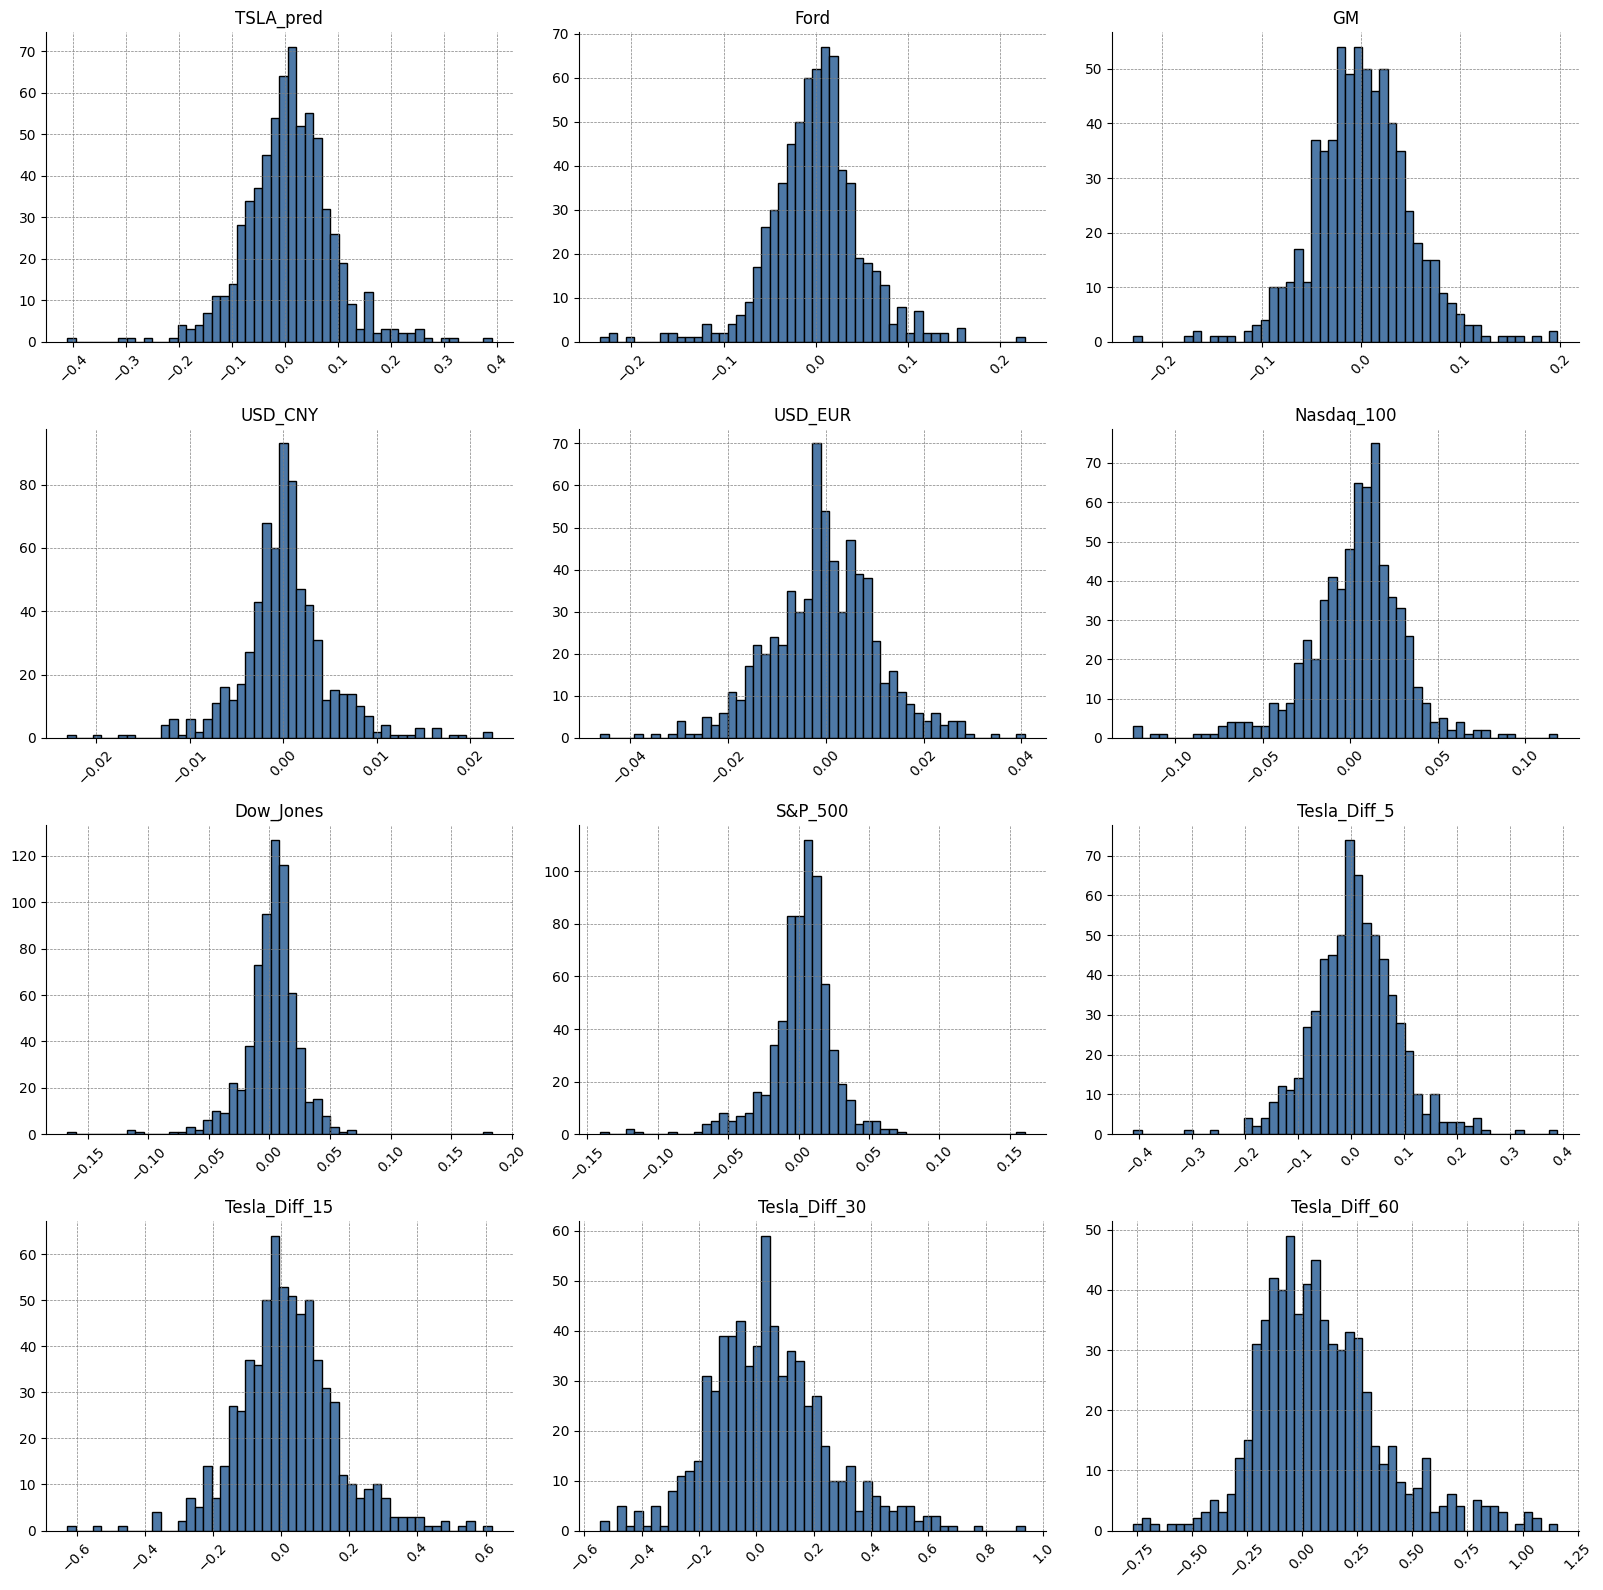

In [9]:
fig = plt.figure(figsize=(16, 16))
ax = data.hist(
    bins=50,
    sharex=False,
    sharey=False,
    color='#4E79A7',
    edgecolor='black',
    xlabelsize=10,
    ylabelsize=10,
    grid=True,
    figsize=(16, 16)
)

# Customizing  individual subplots
for axis in ax.flatten():
    axis.set_xlabel(axis.get_xlabel(), fontsize=12, labelpad=10)
    axis.set_ylabel(axis.get_ylabel(), fontsize=12, labelpad=10)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.grid(color='gray', linestyle='--', linewidth=0.5)
    axis.tick_params(axis='x', rotation=45)

# Display the updated plots
plt.tight_layout()
plt.show()


- Most distributions are centered around zero with symmetrical shapes, which aligns with typical log return behavior in financial data.
- There are signs of normal distribution in many of the log returns, with occasional slight skewness.

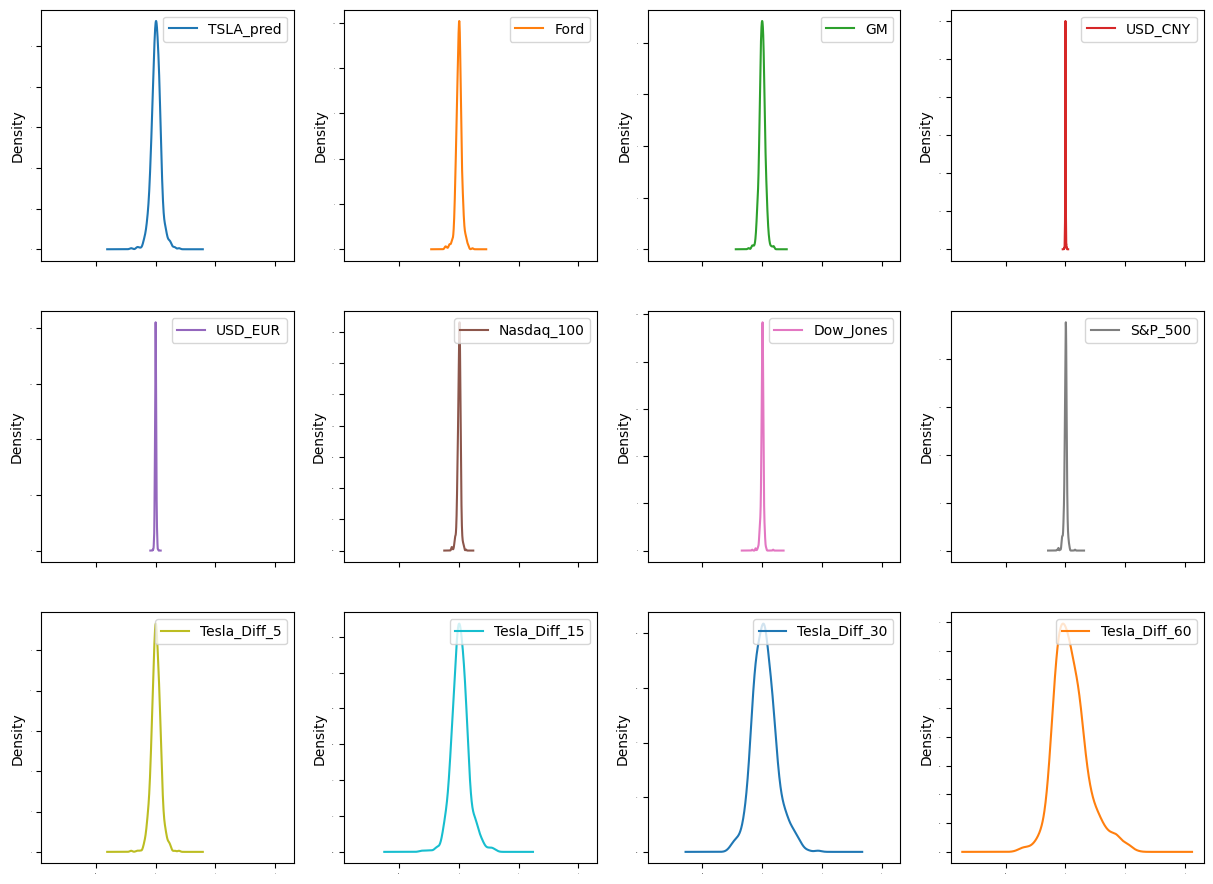

In [10]:
axes = data.plot(kind='density', subplots=True, layout=(4,4), sharex=True,
                 fontsize=1, figsize=(15,15))

# Loop over each axis and add a legend
for i, ax in enumerate(axes.flatten()):
    if ax is not None and i < len(data.columns):
        ax.legend([data.columns[i]], loc='upper right')

plt.show()

We can see that Tesla_diff_60 has a  much larger variance compared to the other distributions.

<Axes: title={'center': 'Correlation Matrix'}>

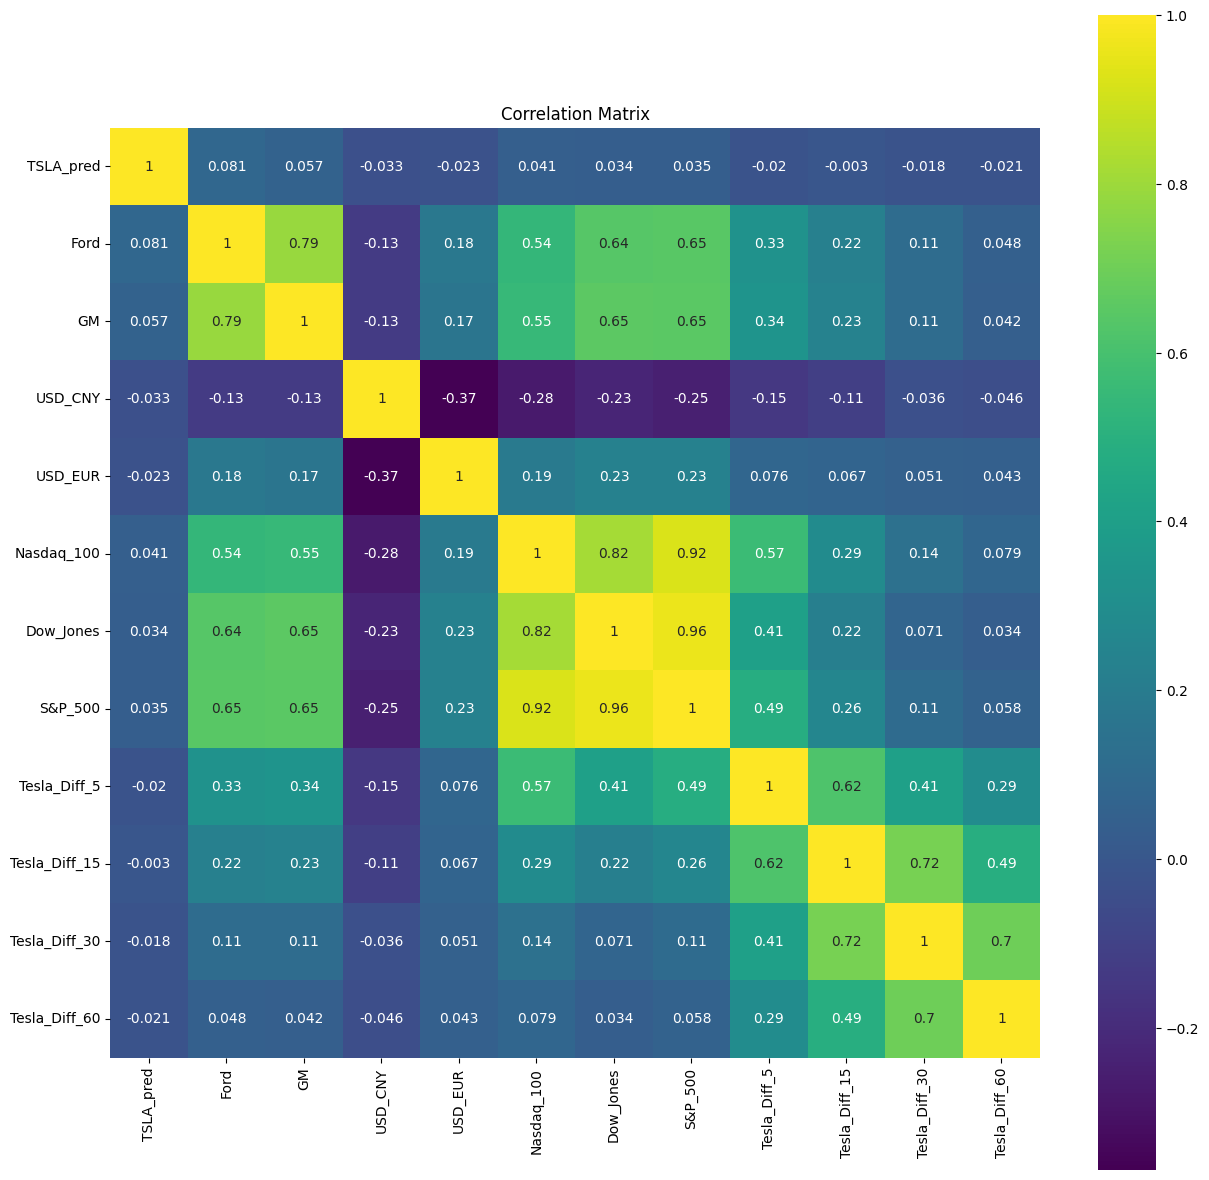

In [11]:
#Correlation
correlation = data.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')

- The correlation matrix shows a strong positive correlation between S&P_500 and Dow_Jones, as well as between S&P_500 and Nasdaq_100, suggesting that these stock indices move together.
- Tesla_Diff variables exhibit moderate positive correlations with each other, indicating a trend in Tesla’s performance over different time intervals.

## Time Series Analysis
We are going decompose our data and have a look at the trend and seasonality in our dataset.

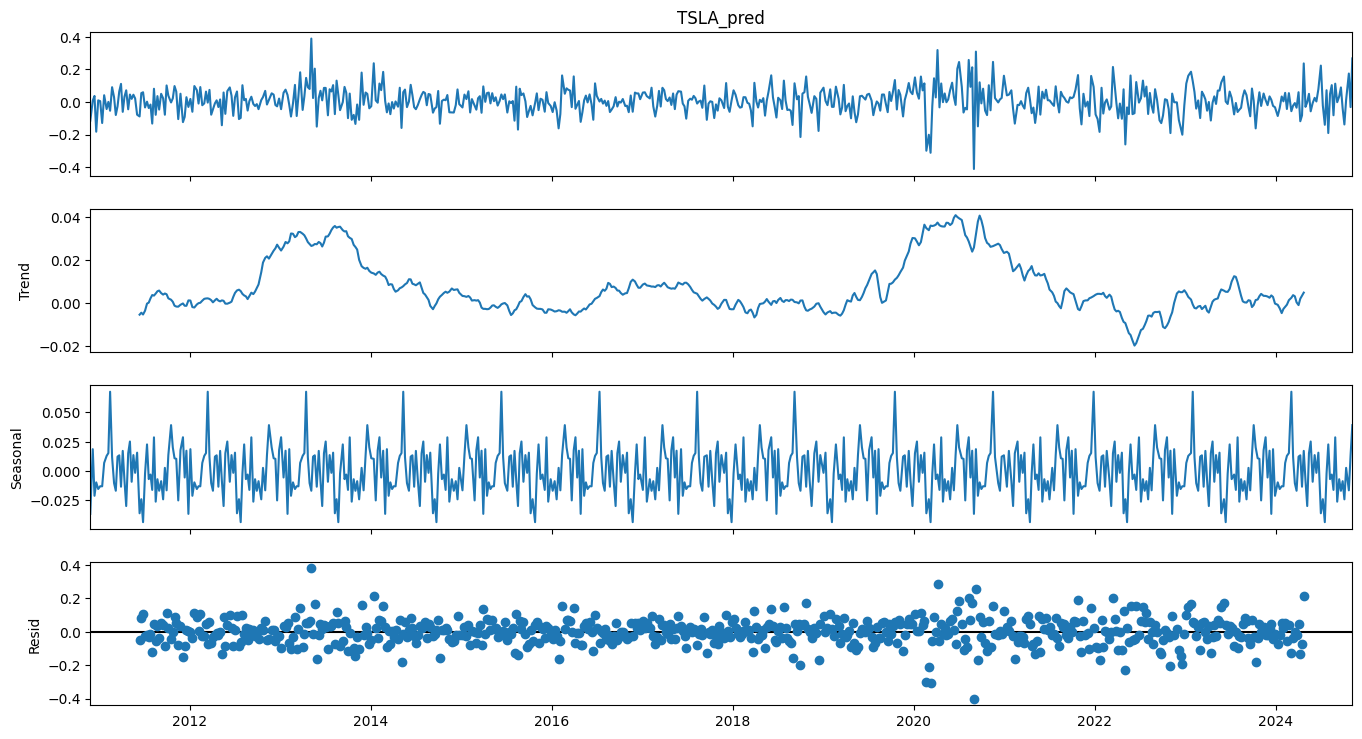

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(data['TSLA_pred'], period=52)

# Plot the decomposition
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

- The decomposition of the TSLA_pred time series reveals a steady upward trend over time, along with regular seasonal fluctuations.
- The residual plot shows mostly random variation around zero, indicating that the trend and seasonal components have effectively captured the primary patterns in the data.

## Data Preparation


### Feature selection

- We use sklearn's SelectKBest function to get a sense of feature importance.

In [13]:
# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


X = data.drop('TSLA_pred', axis=1)
y = data['TSLA_pred']

bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
Ford,4.385729
GM,2.159260
Nasdaq_100,1.098971
S&P_500,0.833201
Dow_Jones,0.751032
USD_CNY,0.734526
USD_EUR,0.338224
Tesla_Diff_60,0.290919
Tesla_Diff_5,0.277654


- We see that Ford seems to be the most important feature and Tesla_Diff_30 being the least important.

### Train test and split

With time series data, the sequence of values is important. So we do not distribute the dataset into training and test sets in random fashion, but we select an arbitrary split point in the ordered list of observations and create two new datasets

In [14]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = y[0:train_size], y[train_size:len(X)]

In [15]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((534, 11), (134, 11), (534,), (134,))

# Model Training And Model Selection

In [16]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.2 MB/s eta 0:00:00


In [17]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

#evaluation
from sklearn.metrics import mean_absolute_error,mean_squared_error



from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [18]:
num_folds = 10
seed = 7
 # In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error'

In [19]:
# Dictionary of models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "CatBoost Regressor": CatBoostRegressor(verbose=False),
    "XGB Regressor": XGBRegressor()
}

# Initialize lists to store MSE values
train_mse_scores = []
test_mse_scores = []

# Set up k-fold cross-validation
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'  # Using neg_mean_squared_error to align with MSE

for name, model in models.items():
    # K-fold cross-validation for each model
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)

    # Store cross-validation MSE (convert negative values to positive)
    train_mse = -cv_results.mean()
    train_mse_scores.append(train_mse)

    # Train the model
    model.fit(X_train, Y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate test MSE
    test_mse = mean_squared_error(Y_test, y_test_pred)
    test_mse_scores.append(test_mse)

    # Print results for each model
    print(name)
    print('----------------------------------')
    print('Train MSE (Cross-Validation): {:.4f}'.format(train_mse))
    print('Test MSE: {:.4f}'.format(test_mse))
    print('='*35)
    print('\n')

# Optional: Print a summary of all models' MSE scores
print("Summary of MSE scores:")
for name, train_mse, test_mse in zip(models.keys(), train_mse_scores, test_mse_scores):
    print(f"{name} - Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")


Linear Regression
----------------------------------
Train MSE (Cross-Validation): 0.0068
Test MSE: 0.0082


Lasso
----------------------------------
Train MSE (Cross-Validation): 0.0065
Test MSE: 0.0080


Ridge
----------------------------------
Train MSE (Cross-Validation): 0.0066
Test MSE: 0.0080


K-Neighbors Regressor
----------------------------------
Train MSE (Cross-Validation): 0.0079
Test MSE: 0.0088


Decision Tree
----------------------------------
Train MSE (Cross-Validation): 0.0129
Test MSE: 0.0178


Random Forest Regressor
----------------------------------
Train MSE (Cross-Validation): 0.0071
Test MSE: 0.0082


CatBoost Regressor
----------------------------------
Train MSE (Cross-Validation): 0.0073
Test MSE: 0.0085


XGB Regressor
----------------------------------
Train MSE (Cross-Validation): 0.0082
Test MSE: 0.0088


Summary of MSE scores:
Linear Regression - Train MSE: 0.0068, Test MSE: 0.0082
Lasso - Train MSE: 0.0065, Test MSE: 0.0080
Ridge - Train MSE: 0.0066,

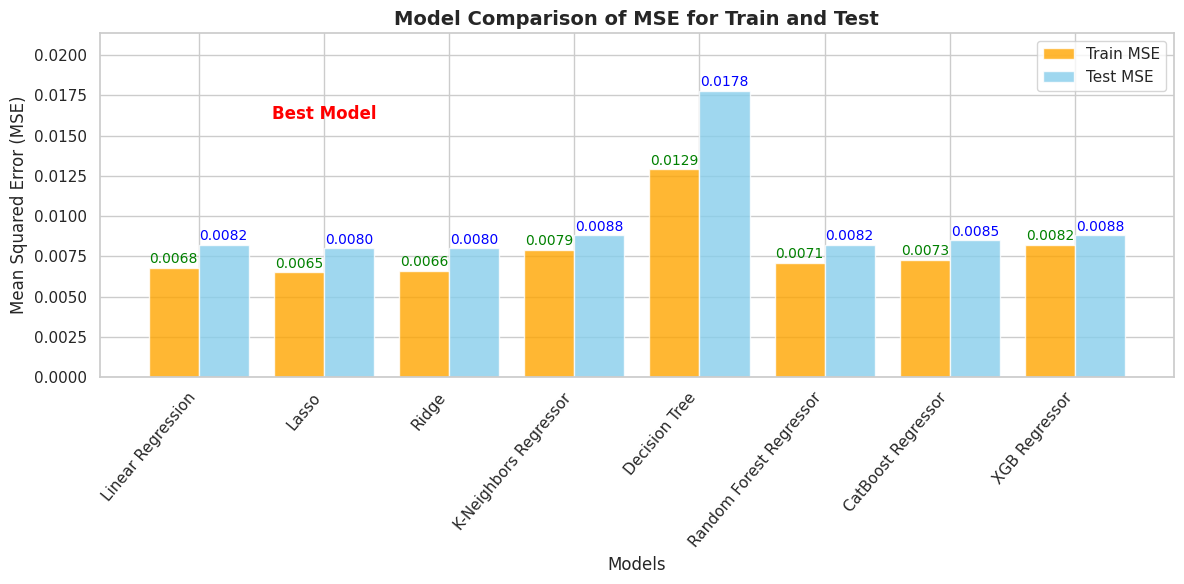

In [34]:
# MSE values for different models
models = [
    "Linear Regression", "Lasso", "Ridge",
    "K-Neighbors Regressor", "Decision Tree",
    "Random Forest Regressor", "CatBoost Regressor", "XGB Regressor"
]
train_mse = [0.0068, 0.0065, 0.0066, 0.0079, 0.0129, 0.0071, 0.0073, 0.0082]
test_mse = [0.0082, 0.0080, 0.0080, 0.0088, 0.0178, 0.0082, 0.0085, 0.0088]

x = np.arange(len(models))  # positions for the models
width = 0.4  # width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
train_bars = ax.bar(x - width / 2, train_mse, width, label='Train MSE', color='orange', alpha=0.8)
test_bars = ax.bar(x + width / 2, test_mse, width, label='Test MSE', color='skyblue', alpha=0.8)

# Add text labels on bars
for bar in train_bars:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.0001, f"{bar.get_height():.4f}",
            ha='center', va='bottom', fontsize=10, color='green')
for bar in test_bars:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.0001, f"{bar.get_height():.4f}",
            ha='center', va='bottom', fontsize=10, color='blue')

# Highlight the best model
best_model_index = train_mse.index(min(train_mse))  # Based on minimum Train MSE
ax.text(x[best_model_index], max(train_mse + test_mse) * 0.9, "Best Model",
        color='red', ha='center', fontsize=12, fontweight='bold')

# Set labels and title
ax.set_xlabel("Models", fontsize=12)
ax.set_ylabel("Mean Squared Error (MSE)", fontsize=12)
ax.set_title("Model Comparison of MSE for Train and Test", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=50, ha='right')
ax.legend()

# Set y-axis limits for better visualization
ax.set_ylim(0, max(train_mse + test_mse) * 1.2)

# Show plot
plt.tight_layout()
plt.show()






- Linear Regression, Lasso and  Ridge have moderate MSE for both train and test sets, showing relatively consistent performance without severe overfitting.
- Decision Tree has the highest test MSE, indicating it may be overfitting to the training data.
- Random forest , CatBoost and XGB also perfomed well on the training and test data.

## Time Series based models-ARIMA and LSTM
-The models used so far already embed the time series component by using a time-delay approach, where the lagged variable is included as one of the independent variables. However, for the time series–based models we do not need the lagged variables of TESLA as the independent variables.We use all other variables as the exogenous variables in these models.



In [21]:
!pip install scikeras

In [25]:
# Time series Models
from statsmodels.tsa.arima_model import ARIMA

#Deep learning libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from scikeras.wrappers import KerasRegressor

### ARIMA

In [26]:
X_train_ARIMA=X_train.loc[:, ['Ford', 'GM', 'USD_CNY', 'USD_EUR', 'S&P_500', 'Dow_Jones',
       'Nasdaq_100']]
X_test_ARIMA=X_test.loc[:, ['Ford', 'GM', 'USD_CNY', 'USD_EUR', 'S&P_500', 'Dow_Jones',
       'Nasdaq_100']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

tr_len,te_len,to_len

(534, 134, 668)

In [27]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning

warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Define and fit a simple ARIMA model with exogenous variables
model_ARIMA = ARIMA(Y_train, exog=X_train_ARIMA, order=(1, 0, 0))
model_fit = model_ARIMA.fit()

In [28]:
# Calculate training MSE for ARIMA
train_predictions_ARIMA = model_fit.predict(start=0, end=len(Y_train)-1, exog=X_train_ARIMA)
error_Training_ARIMA = mean_squared_error(Y_train, train_predictions_ARIMA)

# Calculate test MSE for ARIMA
test_predictions_ARIMA = model_fit.forecast(steps=len(Y_test), exog=X_test_ARIMA)
error_Test_ARIMA = mean_squared_error(Y_test, test_predictions_ARIMA)

# Display the results
print("Training MSE:", error_Training_ARIMA)
print("Test MSE:", error_Test_ARIMA)




Training MSE: 0.006361829569498969
Test MSE: 0.008062096784507856


### LSTM
The logic behind the LSTM is that data is taken from the previous day (the data of all the other features for that day—correlated assets and the lagged variables of TESLA) and we try to predict the next day. Then we move the one-day window with one day and again predict the next day. We iterate like this over the whole dataset (of course in batches)

- The code below will create a dataset in which X is the set of independent variables at a given time (t) and Y is the target variable at the next time (t + 1):

In [29]:
seq_len = 2  # Length of the sequence for the LSTM

# Adjust Y_train_LSTM to match X_train_LSTM length
Y_train_LSTM = np.array(Y_train)[seq_len:]
Y_test_LSTM = np.array(Y_test)[seq_len:]

# Prepare X_train_LSTM with the same sequence length
X_train_LSTM = np.zeros((X_train.shape[0] - seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0] - seq_len, seq_len, X_test.shape[1]))

for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0] - seq_len + i, :]
    X_test_LSTM[:, i, :] = np.array(X_test)[i:X_test.shape[0] - seq_len + i, :]

# Adjust X_test_LSTM to match Y_test_LSTM
X_test_LSTM = X_test_LSTM[:len(Y_test_LSTM)]

# Verify the shapes now match
print("X_train_LSTM shape:", X_train_LSTM.shape)
print("Y_train_LSTM shape:", Y_train_LSTM.shape)
print("X_test_LSTM shape:", X_test_LSTM.shape)
print("Y_test_LSTM shape:", Y_test_LSTM.shape)


X_train_LSTM shape: (532, 2, 11)
Y_train_LSTM shape: (532,)
X_test_LSTM shape: (132, 2, 11)
Y_test_LSTM shape: (132,)


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import SGD

# LSTM Network with simplified structure
def create_LSTM_model(learn_rate=0.01, momentum=0.0):
    model = Sequential()
    # Add LSTM layer
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    # Add Dense output layer for regression
    model.add(Dense(1))

    # Set optimizer with specified learning rate and momentum
    optimizer = SGD(learning_rate=learn_rate, momentum=momentum)
    # Compile the model
    model.compile(loss='mse', optimizer=optimizer)  # Mean Squared Error for regression tasks

    return model

# Initialize the LSTM model
LSTM_model = create_LSTM_model(learn_rate=0.01, momentum=0.0)

# Fit the model
history = LSTM_model.fit(
    X_train_LSTM,
    Y_train_LSTM,
    validation_data=(X_test_LSTM, Y_test_LSTM),
    epochs=330,
    batch_size=72,
    verbose=0,
    shuffle=False  # No shuffling for time-series data
)




In [31]:
# Calculate training MSE for LSTM
train_predictions_LSTM = LSTM_model.predict(X_train_LSTM)
error_Training_LSTM = mean_squared_error(Y_train_LSTM, train_predictions_LSTM)

# Calculate test MSE for LSTM
test_predictions_LSTM = LSTM_model.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test_LSTM, test_predictions_LSTM)

# Display the results
print("Training MSE:", error_Training_LSTM)
print("Test MSE:", error_Test_LSTM)



17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training MSE: 0.006544574200438198
Test MSE: 0.0083456248257828


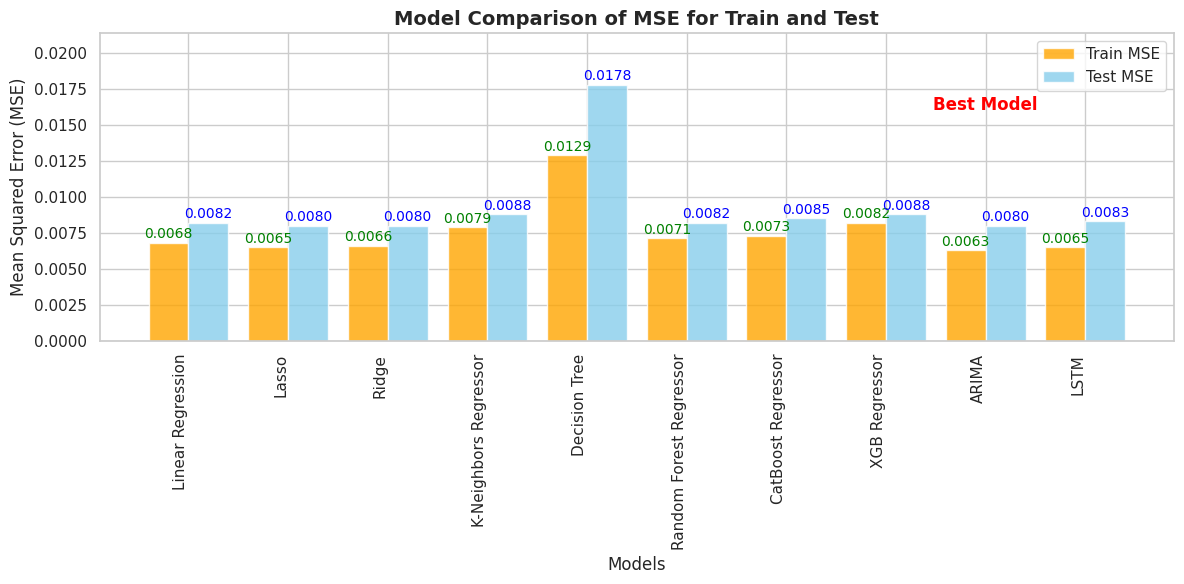

In [33]:
# Adding the ARIMA and LSTM results to the MSE score lists
models = [
    "Linear Regression", "Lasso", "Ridge",
    "K-Neighbors Regressor", "Decision Tree",
    "Random Forest Regressor", "CatBoost Regressor", "XGB Regressor","ARIMA","LSTM"
]
train_mse = [0.0068, 0.0065, 0.0066, 0.0079, 0.0129, 0.0071, 0.0073, 0.0082, 0.0063, 0.0065]
test_mse = [0.0082, 0.0080, 0.0080, 0.0088, 0.0178, 0.0082, 0.0085, 0.0088, 0.0080, 0.0083]

x = np.arange(len(models))  # positions for the models
width = 0.4  # width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
train_bars = ax.bar(x - width / 2, train_mse, width, label='Train MSE', color='orange', alpha=0.8)
test_bars = ax.bar(x + width / 2, test_mse, width, label='Test MSE', color='skyblue', alpha=0.8)

# Add text labels on bars
for bar in train_bars:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.0001, f"{bar.get_height():.4f}",
            ha='center', va='bottom', fontsize=10, color='green')
for bar in test_bars:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.0001, f"{bar.get_height():.4f}",
            ha='center', va='bottom', fontsize=10, color='blue')

# Highlight the best model
best_model_index = train_mse.index(min(train_mse))  # Based on minimum Train MSE
ax.text(x[best_model_index], max(train_mse + test_mse) * 0.9, "Best Model",
        color='red', ha='center', fontsize=12, fontweight='bold')

# Set labels and title
ax.set_xlabel("Models", fontsize=12)
ax.set_ylabel("Mean Squared Error (MSE)", fontsize=12)
ax.set_title("Model Comparison of MSE for Train and Test", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=90, ha='right')
ax.legend()

# Set y-axis limits for better visualization
ax.set_ylim(0, max(train_mse + test_mse) * 1.2)

# Show plot
plt.tight_layout()
plt.show()

- we can see that the ARIMA perfomed better than the other models it also perfomed better than the LSTM
- Next step we will tune the ARIMA model.

## Tuning the ARIMA model

In [45]:
import itertools
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)



# Define a grid of ARIMA parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)

# Store the results
best_model = None
best_order = None
lowest_mse = float("inf")

# Perform grid search
for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(Y_train, order=(p, d, q), exog=X_train_ARIMA)
        model_fit = model.fit()
        train_predictions = model_fit.predict(start=0, end=len(Y_train)-1, exog=X_train_ARIMA)
        mse = mean_squared_error(Y_train, train_predictions)

        if mse < lowest_mse:
            lowest_mse = mse
            best_model = model_fit
            best_order = (p, d, q)

    except Exception as e:
        continue

print(f"Best ARIMA Order: {best_order}")
print(f"Lowest Training MSE: {lowest_mse}")



Best ARIMA Order: (2, 0, 1)
Lowest Training MSE: 0.00628769302520421


## Final prediction

In [41]:
# prepare model
model_ARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = model_ARIMA_tuned.fit()

In [42]:
predictions_ARIMA = model_fit_tuned.forecast(steps=len(Y_test), exog=X_test_ARIMA)
error_Test_ARIMA = mean_squared_error(Y_test, predictions_ARIMA )
print("Test MSE:", error_Test_ARIMA)

Test MSE: 0.00809992922747409


## Saving the model

In [48]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'model_ARIMA_tuned.sav'
dump(model_fit_tuned, open(filename, 'wb'))

- We can conclude that simple models - linear regression, regularized regression (i.e. Lasso and Ridge ) along with the time series model such as ARIMA are promising modelling approaches for TESLA stock  price prediction problem.These models can enable financial practitioners to model time dependencies with a very flexible approach.
- Including  other  set of indicators, such as P/E ratio, trading volume, technical indicators or news data  might lead to better results.
-The main challenge is the model might be prone to overfitting but with the right tuning and adjustments we can achive a state of art results